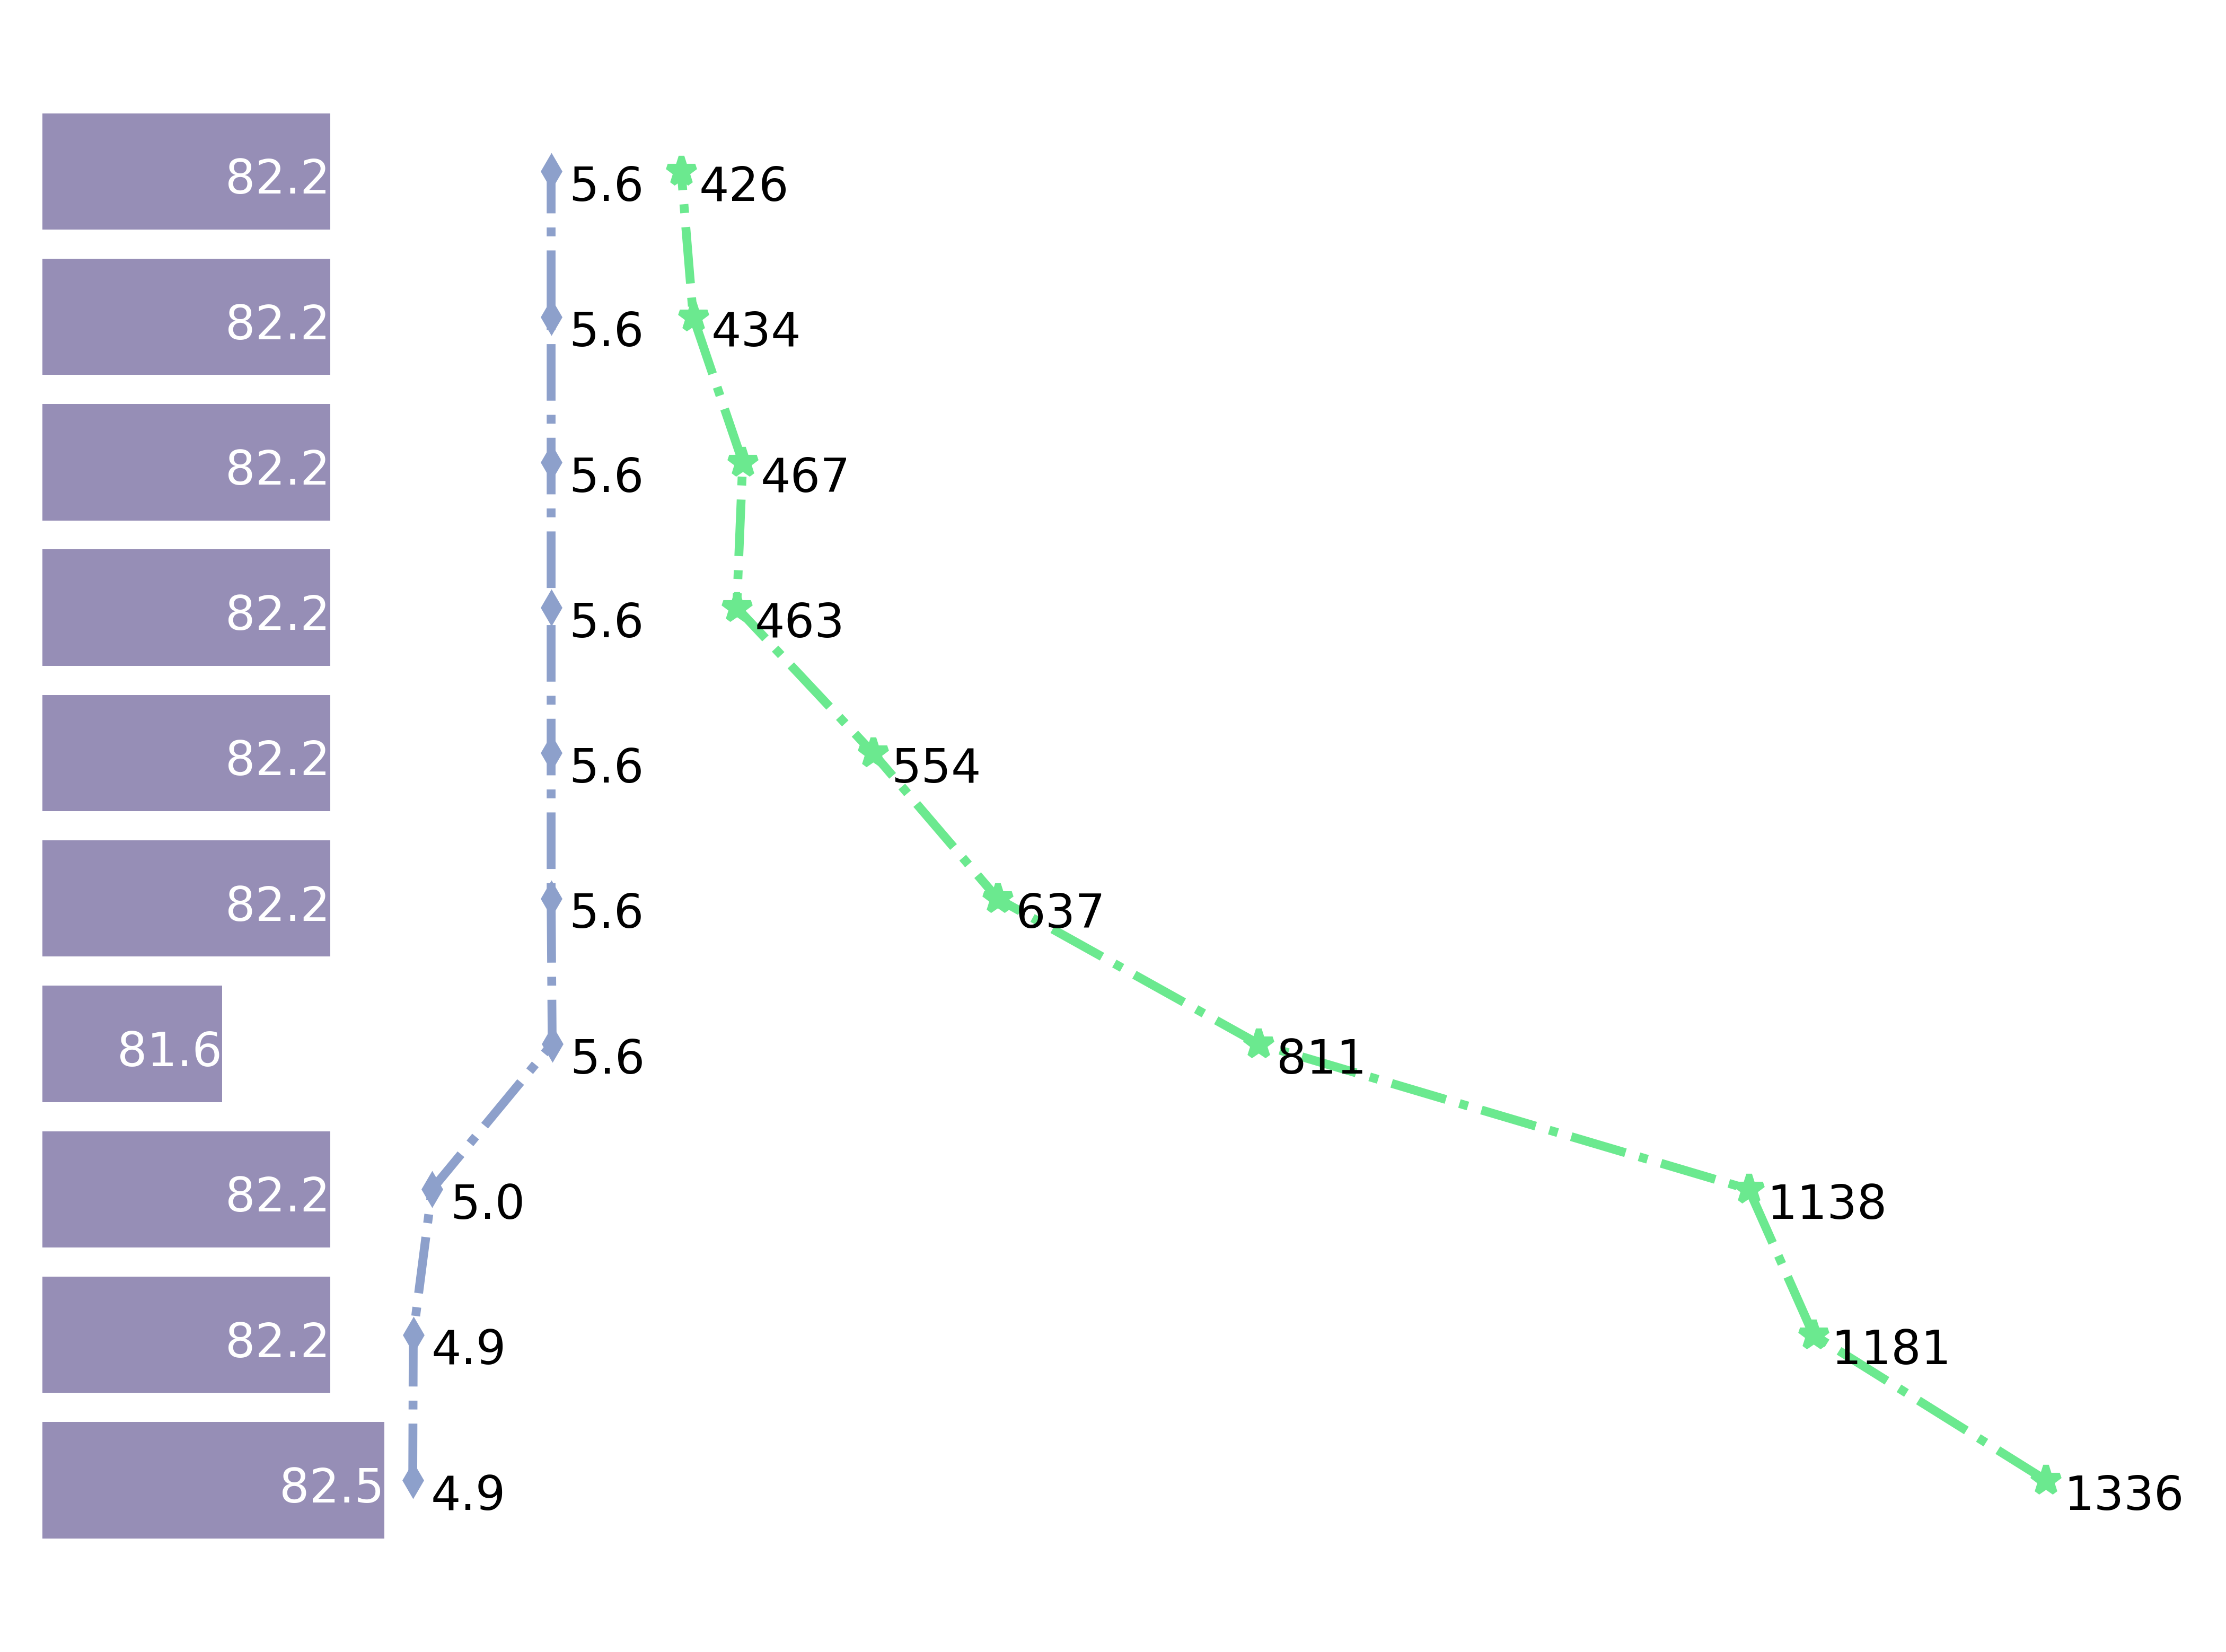

In [77]:
def speedup():
    # params, flops, throughput, train-throughput, peformance
    models = [
        [22.9, 5.627, 426, 138, 82.2, "V0", "original"],
        [22.9, 5.627, 434, 157, 82.2, "V1", "csm manual gradient"],
        [22.9, 5.627, 467, 165, 82.2, "V2", "csm triton"],
        [22.9, 5.627, 463, 184, 82.2, "V3", "fp16 in. & fp32 out."],
        [22.9, 5.627, 554, 200, 82.2, "V4", "einsum -> F.linear"],
        [22.9, 5.627, 637, 195, 82.2, "V5", "bchw layout"],
        [29.0, 5.633, 811, 248, 81.6, "V6", "dwconv -> MLPs"],
        [27.5, 4.965, 1138, 356, 82.2, "V7", "more layers"],
        [26.2, 4.861, 1181, 361, 82.2, "V8", "no branch skip"],
        [30.7, 4.858, 1336, 463, 82.5, "V9", "bigger SSM Ratio"],
    ]
    models = models[::-1]
    x = [i for i, m in enumerate(models)]
    flops = [m[1] for i, m in enumerate(models)]
    tps = [m[2]  for i, m in enumerate(models)]
    perfs = [m[4] for i, m in enumerate(models)]

    import matplotlib.pyplot as plot
    plot.figure(edgecolor="w", dpi=800)
    plot.axis("off")

    rects = plot.barh(x, [d - 80.6 for d in perfs], color="#968eb6")
    for rect, perf in zip(rects, perfs):
        _x, _y, _w, _h = rect.get_x(), rect.get_y(), rect.get_width(), rect.get_height()
        plot.text(_x + _w, _y + _h / 2 - 0.15, f"{perf:.1f}", color="w", size=8, horizontalalignment="right")

    plot.plot([d - 2.8 for d in flops], x, color='#8da0cb', linestyle='-.', marker='d', markersize=3)
    for _x, _y, _d, in zip([d - 2.8 for d in flops], x, flops):
        plot.text(_x + 0.1, _y - 0.2, f"{_d:.1f}", color="black", size=8, horizontalalignment="left")

    plot.plot([d / 120 for d in tps], x, color='#6be98f', linestyle='-.', marker='*', markersize=5)
    for _x, _y, _d, in zip([d / 120 for d in tps], x, tps):
        plot.text(_x + 0.1, _y - 0.2, f"{_d:.0f}", color="black", size=8, horizontalalignment="left")
    
    plot.xticks([])
    plot.yticks([])
    plot.show()
    22

speedup()
    

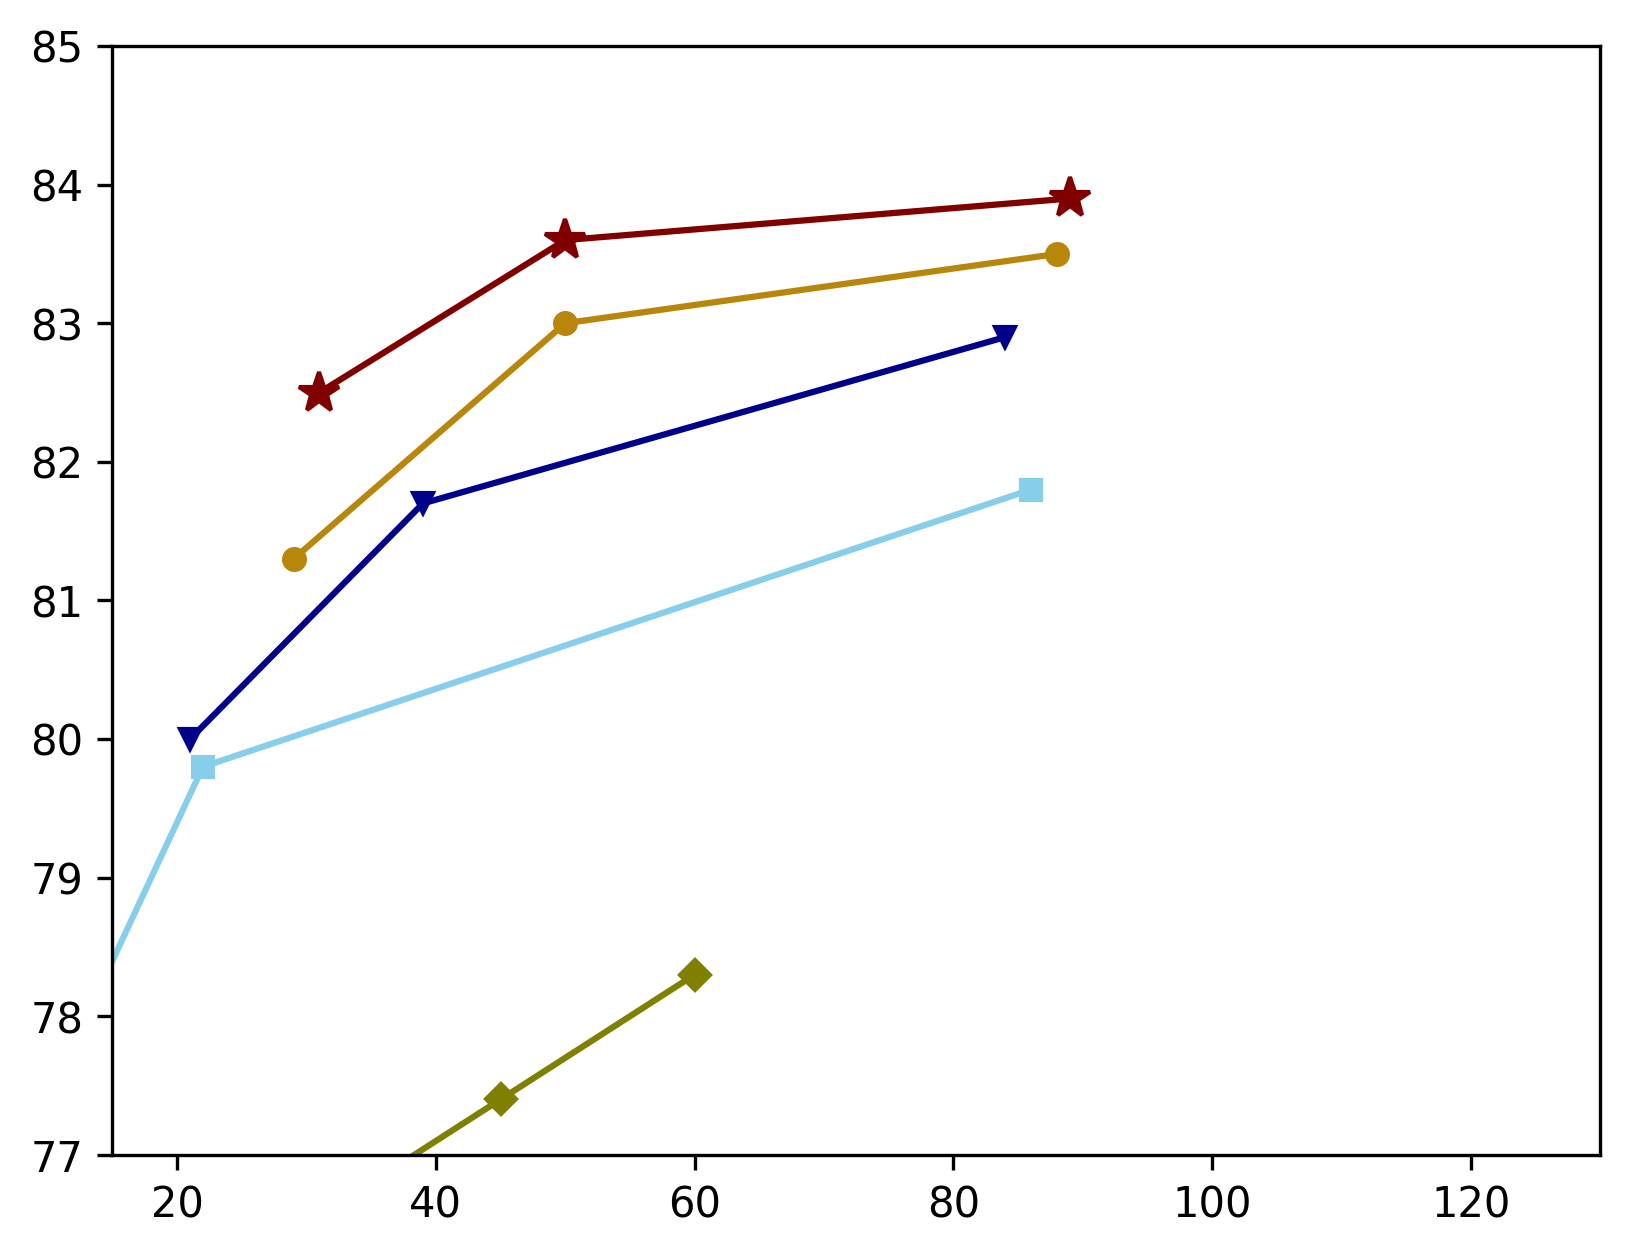

In [3]:
def comp():
    import matplotlib.pyplot as plt
    import numpy as np
    regnet = [[21, 4, 1156.7, 80], [39, 8, 591.6, 81.7], [84, 16, 334.7, 82.9]]
    effnet = [[12, 1.8, 732.1, 81.6], [19, 4.2, 349.4, 82.9],
            [30, 9.9, 169.1, 83.6], [43, 19, 96.9, 84],
            [66, 37, 55.1, 84.3]]
    resnet= [[12, 0, 4458.4, 69.8], [25, 0, 1226.1, 76.2], [45, 0, 753.6, 77.4], [60, 0, 526.4, 78.3]]
    vit = [[86, 55.4, 85.9, 77.9]]
    deit = [[6, 0, 2529.5, 76.6], [22, 4.6, 940.4, 79.8], [86, 17.5, 292.3, 81.8]]
    swin = [[29, 4.5, 755.2, 81.3], [50, 8.7, 436.9, 83], [88, 15.4, 278.1, 83.5]]
    vmamba = [[31, 4.9, 0, 82.5], [50, 8.7, 0, 83.6], [89, 15.4, 0, 83.9]]

    def extract_xy(net):
        npnet = np.array(net)
        x = npnet[:, 0].tolist()
        y = npnet[:, -1].tolist()
        return x, y

    plt.figure(dpi=300)
    plt.xlim(15, 130)
    plt.ylim(77, 85)
    plt.plot(*extract_xy(regnet), marker='v', markersize=5, c='darkblue', label="RegNetY")
    # plt.plot(*extract_xy(effnet), c='purple', label="EffNet")
    # plt.plot(*extract_xy(vit), marker='D', markersize=7, c='yellow', label="ViT")
    plt.plot(*extract_xy(resnet), marker='D', markersize=5, c='olive', label="ResNet")
    plt.plot(*extract_xy(deit), c='skyblue',marker='s', markersize=5, label="DeiT")
    plt.plot(*extract_xy(swin), c='darkgoldenrod',marker='o', markersize=5, label="swin")
    plt.plot(*extract_xy(vmamba), c='maroon', marker='*', markersize=10, label="vmamba")
    plt.show()

comp()

In [52]:
def get_bidi(size, center1d=1):
    import torch
    mask_stop1d = torch.ones((size,), dtype=torch.bool)
    mask_stop1d[center1d + 1:] = 0

    bidiscan = (torch.arange(0, size) * mask_stop1d)
    bidiscan += (torch.arange(0, size).flip(dims=[0]) * (~mask_stop1d))
    center_left = bidiscan[center1d - 1].clone()
    center_right = bidiscan[center1d + 1].clone()
    bidiscan[:center1d + 1] += center_right
    bidiscan[center1d + 1:] += center_left
    bidiscan = (bidiscan - bidiscan.min())
    return bidiscan

def maps(size=7, center=(3, 3)):
    import torch
    from erf import visualize
    center1d = size * center[0] + center[1]
    mask_stop1d = torch.ones((size*size,), dtype=torch.bool)
    mask_stop1d[center1d + 1:] = 0
    norm = lambda x: x / x.max()

    mask_stoph = torch.ones((size,), dtype=torch.bool)
    mask_stopw = torch.ones((size,), dtype=torch.bool)
    mask_stoph[center[0]:] = 0
    mask_stopw[center[1]:] = 0

    unidiscan = (torch.arange(0, size*size) * mask_stop1d).view(size, size)

    bidiscan = get_bidi(size*size, size * center[0] + center[1]).view(size, size)

    cascadescan = get_bidi(size, center[0]).view(size, 1).repeat(1, size)
    cascadescan += get_bidi(size, center[1]).view(1, size).repeat(size, 1)

    crossscan = get_bidi(size*size, size * center[1] + center[0]).view(size, size).transpose(0, 1)
    crossscan += get_bidi(size*size, size * center[0] + center[1]).view(size, size)

    visualize.visualize_attnmaps((
        (norm(unidiscan), ""),
        (norm(bidiscan), ""),
        (norm(cascadescan), ""),
        (norm(crossscan), ""),
    ))

maps()




tensor([[ 0,  1,  2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11, 12, 13],
        [14, 15, 16, 17, 18, 19, 20],
        [21, 22, 23, 24,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0]])
tensor([[ 0,  1,  2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11, 12, 13],
        [14, 15, 16, 17, 18, 19, 20],
        [21, 22, 23, 24, 23, 22, 21],
        [20, 19, 18, 17, 16, 15, 14],
        [13, 12, 11, 10,  9,  8,  7],
        [ 6,  5,  4,  3,  2,  1,  0]])
tensor([[0, 1, 2, 3, 2, 1, 0],
        [1, 2, 3, 4, 3, 2, 1],
        [2, 3, 4, 5, 4, 3, 2],
        [3, 4, 5, 6, 5, 4, 3],
        [2, 3, 4, 5, 4, 3, 2],
        [1, 2, 3, 4, 3, 2, 1],
        [0, 1, 2, 3, 2, 1, 0]])
tensor([[ 0,  8, 16, 24, 24, 18, 12],
        [ 8, 16, 24, 32, 30, 24, 18],
        [16, 24, 32, 40, 36, 30, 24],
        [24, 32, 40, 48, 40, 32, 24],
        [24, 30, 36, 40, 32, 24, 16],
        [18, 24, 30, 32, 24, 16,  8],
        [12, 18, 24,